# Querying ERDDAP servers from Python

### Manual query creation

Requests to ERDDAP servers can be generated manually via the web interface. To do this, we visit the page of a dataset e.g. [nrt_SEA068_M27](https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA068_M27.html), select our variables and constraints, specify file type and click `submit`:



![sbumitting a request to ERDDAP](img/erddap_submit_request.png)

This will start the data download. We can also click the `generate URL` button so that we can submit the same query at a later time. 

These urls are quite complex. Here's an example

https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA068_M27.csv?latitude%2Clongitude%2Ctime%2Cdepth%2Coxygen_concentration%2Coxygen_concentration_qc%2Cprofile_direction%2Cprofile_index%2Csalinity%2Csalinity_qc&latitude%3E=58.2275&depth%3E=0&depth%3C=40

Breaking the url down, we see that it sepcifies several things

- `https://erddap.observations.voiceoftheocean.org/erddap` The url of the server
- `tabledap` the protocol, which can be tabledap or griddap
- `nrt_SEA068_M27` the ID of the dataset we want
- `.csv` the requested file format
- `latitude%2Clongitude%2Ctime%2Cdepth%2Coxygen_concentration`... the variables we request
- `latitude%3E=58.2275&depth%3E=0&depth%3C=40`... constraints like time window and geographical extent


**side note** %2C %3C %3A and %3E are the url hexadecimal encodings of the , and : < and > symbols respectively. We can decode these special characters with python for a more readable url:

In [1]:
from urllib.parse import unquote
unquote("https://erddap.observations.voiceoftheocean.org/erddap/tabledap/"
        "nrt_SEA068_M27.csv?latitude%2Clongitude%2Ctime%2Cdepth%2Coxygen_concentration"
        "%2Coxygen_concentration_qc%2Cprofile_direction%2Cprofile_index%2Csalinity%2C"
        "salinity_qc&latitude%3E=58.2275&depth%3E=0&depth%3C=40")

'https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA068_M27.csv?latitude,longitude,time,depth,oxygen_concentration,oxygen_concentration_qc,profile_direction,profile_index,salinity,salinity_qc&latitude>=58.2275&depth>=0&depth<=40'

Creating these urls manually quickly becomes tedious, especially if a user wishes to download the same subset of data from several datasets. There are several tools in Python to assist this process of url generation and submission. Today we will use [erddapy](https://github.com/ioos/erddapy)

### Automated query creation

In [2]:
from erddapy import ERDDAP

We build a query in steps to generate a url like the one broken down above

In [3]:
e = ERDDAP(
    server="https://erddap.observations.voiceoftheocean.org/erddap", # server
    protocol="tabledap", # protocol
)

In [4]:
e.dataset_id = "nrt_SEA068_M27" # dataset ID

In [5]:
e.variables = [
     'latitude',
     'longitude',
     'time',
     'depth',
     'oxygen_concentration',
     'oxygen_concentration_qc',
     'profile_direction',
     'profile_index',
     'salinity',
     'salinity_qc']

In [6]:

e.constraints = {"latitude>=": 58.2275,
                 "depth>=": 0,
                 "depth<=": 40}


We can now generate the download url

In [7]:
e.get_download_url(response="csv")

'https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA068_M27.csv?latitude,longitude,time,depth,oxygen_concentration,oxygen_concentration_qc,profile_direction,profile_index,salinity,salinity_qc&latitude>=58.2275&depth>=0&depth<=40'

We see that this is identical to the url we manually created early, and it generates an identical response. We can also generate a link to the data selection page with these presets


In [8]:
e.get_download_url(response="html")

'https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA068_M27.html?latitude,longitude,time,depth,oxygen_concentration,oxygen_concentration_qc,profile_direction,profile_index,salinity,salinity_qc&latitude>=58.2275&depth>=0&depth<=40'

Now, if we want to run the same query against many datasets, we just need to change `e.dataset_id` rather than going to the page of each dataset and checking lots of tick boxes

### Download data into Python

The real power of libraries like erddapy lies in how they can generate a query to ERDDAP, submit it, and load the response directly into Python. 

In [9]:
ds = e.to_xarray()

In [10]:
ds

<xarray.Dataset>
Dimensions:                  (timeseries: 60, obs: 957)
Coordinates:
    latitude                 (obs) float64 ...
    longitude                (obs) float64 ...
    time                     (obs) datetime64[ns] ...
    depth                    (obs) float64 ...
Dimensions without coordinates: timeseries, obs
Data variables:
    profile_index            (timeseries) float64 ...
    rowSize                  (timeseries) int32 ...
    oxygen_concentration     (obs) float64 ...
    oxygen_concentration_qc  (obs) float64 ...
    profile_direction        (obs) float64 ...
    salinity                 (obs) float64 ...
    salinity_qc              (obs) float64 ...
Attributes: (12/75)
    acknowledgement:               This study used data collected and made fr...
    basin:                         Eastern Gotland Basin
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      profile_index
    comment:                       deployment and recovery in Skagerrak
    contributor_name:              Callum Rollo, Louise Biddle, Olle Petersso...
    ...                            ...
    title:                         Aster68-20220727T1709
    total_dives:                   28.0
    transmission_system:           IRIDIUM
    variables:                     time\nlatitude\nlongitude\nnav_state\nhead...
    Westernmost_Easting:           19.90615
    wmo_id:                        6801602

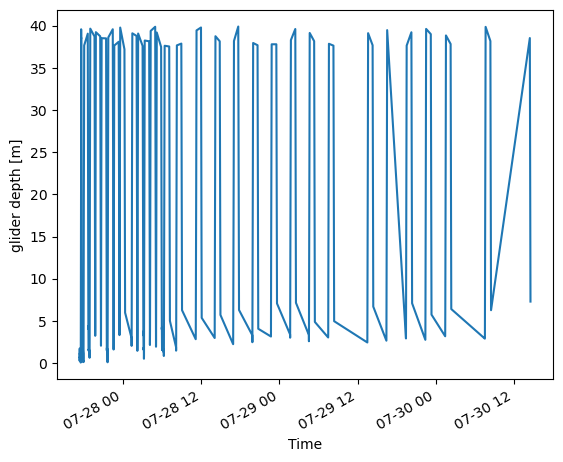

In [11]:
ds.depth.plot(x="time")

erddapy typically fetches data in netCDF format, as Python can process this format and, unlike csv, it contains all of the metadata specified by the data provider.

If metadata are not required, erddapy can return a pandas DataFrame instead.

In [12]:
df = e.to_pandas()

In [13]:
df

,latitude (degrees_north),longitude (degrees_east),time (UTC),depth (m),oxygen_concentration (MMol' 'M-3),oxygen_concentration_qc,profile_direction (1),profile_index (1),salinity (1e-3),salinity_qc
0,58.254767,19.961617,2022-07-27T17:20:12Z,0.618601,264.5688,3,1,0,6.286969,1
1,58.254733,19.961617,2022-07-27T17:20:42Z,0.265115,262.2029,3,1,0,6.283809,1
2,58.254717,19.961667,2022-07-27T17:21:12Z,0.505362,262.8863,3,1,0,6.284135,1
3,58.254717,19.961617,2022-07-27T17:21:42Z,1.732652,264.4326,3,1,0,6.285467,1
4,58.254733,19.961550,2022-07-27T17:22:12Z,1.032618,263.8905,3,1,0,6.282441,1
...,...,...,...,...,...,...,...,...,...,...
952,58.229667,19.935083,2022-07-30T14:31:08Z,16.061941,240.2647,3,-1,69,6.649511,1
953,58.229717,19.935167,2022-07-30T14:31:38Z,14.436893,247.7996,3,-1,69,6.639510,1
954,58.229733,19.935200,2022-07-30T14:32:08Z,12.330274,252.8405,3,-1,69,6.638876,1
955,58.229783,19.935267,2022-07-30T14:32:38Z,9.990925,259.3508,3,-1,69,6.612011,1


-------------------------------

**References**

ERDDAP documentation https://erddap.observations.voiceoftheocean.org/erddap/information.html

erddapy documentation https://ioos.github.io/erddapy/